<a href="https://colab.research.google.com/github/AraiKensuke/AIiRPS/blob/master/Launch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inferring NGS(k) from iRPS gameplay data**

The NGS(k) (9 components) represents the conditional probabilities staying with, downgrading or upgrading current hand a after a win, tie or loss (3 x 3 conditions describing all possible transitions).  We infer this from data using latent-state model with a multinomial observation.

First we clone and install packages necessary.  Please run the following cell.

You'll see some output and compile messages as there's some parts written in C.

In [ ]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("AIiRPS") is None:
  !git clone https://github.com/AraiKensuke/AIiRPS.git
if importlib.util.find_spec("pyPG") is None:
  ###  First, clone the pyPG package from Github.  This will only last for this runtime session.  Do this every time you re-open notebook.
  !git clone https://github.com/AraiKensuke/pyPG.git
  %cd /content/pyPG/

  ###  pyPG is written in C++/python, and uses the C library GNU Scientific Library.  
  !sudo apt-get install libgsl-dev   

  ###  setup and build pyPG
  !python setup.py build_ext --inplace

  %cd /content   

if importlib.util.find_spec("LOSTtmp") is None:
  ###  LOST  (FFBS algorithm implemented here)
  !git clone https://github.com/AraiKensuke/LOSTtmp.git

  %cd /content/LOSTtmp/
  !python setup.py build_ext --inplace
  %cd /content

sys.path.insert(1, "/content/AIiRPS")
sys.path.insert(1, "/content/pyPG")    #  add these to searchpath for python modules
sys.path.insert(1, "/content/LOSTtmp") #  add these to searchpath for python modules


Now the analysis code.  There are sample data from 5 different players, A-E.  Please uncomment one of the 'dat_fn' variables.  (Coming soon, ability to cut and paste your own data generated from the web iRPS game).



************************   AIiRPS/sampledata/HP_vs_AI/SIMHUM11/20110111/20110111_0000-00/1/block1_AI.dmp
......   open this one     AIiRPS/sampledata/HP_vs_AI/SIMHUM11/20110111/20110111_0000-00/1/block1_AI.dat
0   capped 27767
1000   capped 27767
2000   capped 27767
3000   capped 27767
4000   capped 27767
5000   capped 27808
6000   capped 28808
7000   capped 29808
8000   capped 30808
9000   capped 31808
10000   capped 32808
11000   capped 33808
12000   capped 34808
13000   capped 35808
14000   capped 36808
15000   capped 37808
16000   capped 38808
17000   capped 39808
18000   capped 40808
19000   capped 41808
20000   capped 42808
21000   capped 43808
22000   capped 44808
23000   capped 45808
24000   capped 46808
25000   capped 47808
26000   capped 48808
27000   capped 49808
28000   capped 50808
29000   capped 51808
[0.02299411 0.10540112 0.23358845 ... 0.73370951 0.73713266 0.65780319]
[0.03255276 0.19454724 0.20487219 ... 0.86937273 0.80353223 0.87493519]
0   capped 52808
1000   cappe

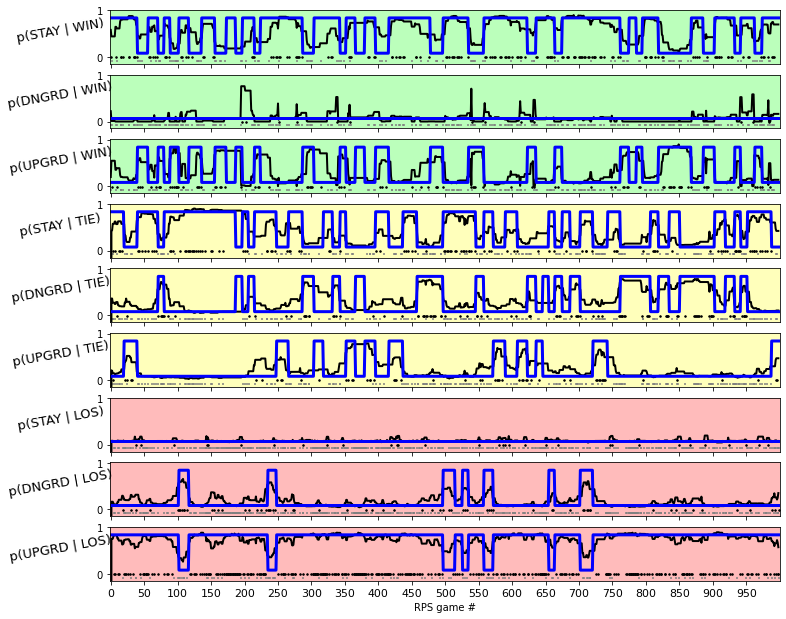

In [6]:
import numpy as _N  #  must import this before pyPG when running from shell
import pickle
import os
os.environ["AIiRPS_on_colab"] = "1"    #  do this before importing read_taisen

import AIiRPS.utils.read_taisen as _rd
import matplotlib.pyplot as _plt
import os
import sys
import AIiRPS.models.labels as labels
#from cmdlineargs import process_keyval_args
import AIiRPS.models.multinomial_gibbs as _mg

from AIiRPS.utils.dir_util import getResultFN

def union_arrs(a1, a2):
     return _N.sort(_N.array(a1.tolist() + a2.tolist()))

def fill_unobserved(arr):
    #  we assume old value is kept until new observation
    nz = _N.where(arr != -100)[0]
    iLastObs = arr[0] if (arr[0] != -100) else _N.mean(arr[nz])
    for i in range(1, arr.shape[0]):
        arr[i] = arr[i] if (arr[i] != -100) else iLastObs
        if arr[i] != -100:
            iLastObs = arr[i]
    
def depickle(s):
     import pickle
     with open(s, "rb") as f:
          lm = pickle.load(f)
     return lm

###
#   Here the latent state is B1, B2.
#   Probability of going to stay, weaker, stronger for just the WIN condition
#   

#  input data
#  m_hands    # machine hands  size N         1 -1  1
#  h_hands    # human hands    size N        -1 -1  1
#  -1 -1  1  1 -1  1 
#      0  1  0  1  1

fns     = ["ME,WTL", "ME,RPS", "AI,WTL", "AI,RPS", "OU,WTL", "OU,RPS"]

fnt_tck = 10
fnt_lbl = 12

fnt_tck = 15
fnt_lab = 16

_WTL = 10
_ME_WTL = 0
_RELATIVE_LAST_ME = 1    #  what to use as a comparison for when player switches

smp_every = 50
ITER = 30000
it0  = 28000
it1  = 30000

label=8
#  priors for inv gamma   #  B/(a+1)

rndmz = False

######  AR(1) coefficient range 
a_F0      = -1;    b_F0      =  1

######  int main 
#int i,pred,m,v[3],x[3*N+1],w[9*N+3],fw[3];

know_gt  = True
signal   = _RELATIVE_LAST_ME
covariates = _WTL
sig_cov   = _ME_WTL

tr0      = 0
tr1      = -1

##### data files
dat_fn="20110111_0000-00"

random_walk = False
flip_human_AI=False
#########################################
#process_keyval_args(globals(), sys.argv[1:])
a_q2, B_q2, a_F0, B_F0 = labels.get_a_B_aF0_bF0(label)

scov = "WTL"
ssig = "ME"

if tr1 < 0:
    tr1 = None
sran   = ""

s_flip = "_flip" if flip_human_AI else ""
#if not know_gt: 
_hnd_dat, start_time, end_time, UA, cnstr, inp_meth, ini_percep, fin_percep, lmGT = _rd.return_hnd_dat(dat_fn, flip_human_AI=flip_human_AI, know_gt=True, expt="SIMHUM11", visit=1, has_useragent=True, has_start_and_end_times=True, has_constructor=True, )    

#else:
#    _hnd_dat     = _N.loadtxt("/Users/arai/nctc/Workspace/AIiRPS_SimDAT/rpsm_%s.dat" % dat_fn, dtype=_N.int)
#    lmGT = depickle("/Users/arai/nctc/Workspace/AIiRPS_SimDAT/rpsm_%s.dmp" % dat_fn)
#    Ts = lmGT["Ts_timeseries"]
    
if tr1 is None:
    tr1          = _hnd_dat.shape[0]
    rr_hnd_dat     = _N.array(_hnd_dat)
else:
    rr_hnd_dat      = _N.array(_hnd_dat[tr0:tr1])

inds = _N.arange(tr1)        
if rndmz:
    _N.random.shuffle(inds)
    sran = "rndmz"
hnd_dat = _N.array(rr_hnd_dat[inds])
N_all  = hnd_dat.shape[0]-1
smp_offsets_all = _N.empty((6, ITER))
smp_Bns_all     = _N.ones((6, ITER, N_all))*-100

conds = []
conds.append(_N.where(hnd_dat[0:-1, 2] == 1)[0])   #  WIN
conds.append(_N.where(hnd_dat[0:-1, 2] == 0)[0])   #  TIE
conds.append(_N.where(hnd_dat[0:-1, 2] == -1)[0])  #  LOSE

#out_dir = getResultFN("%(dfn)s" % {"dfn" : dat_fn})
#if not os.access(out_dir, os.F_OK):
#    os.mkdir(out_dir)
#out_dir = getResultFN("%(dfn)s/%(lbl)d" % {"dfn" : dat_fn, "lbl" : label})
#if not os.access(out_dir, os.F_OK):
#    os.mkdir(out_dir)

col_n0 = 0    #  current
col_n1 = 0    #  previous

#  can't directly use hnd_dat, as it condX are discontinuous, 

stay_win, wekr_win, strg_win, \
     stay_tie, wekr_tie, strg_tie, \
     stay_los, wekr_los, strg_los, \
     win_cond, tie_cond, los_cond = _rd.get_ME_WTL(hnd_dat, tr0, tr1)
    #  p(stay | W)     

nWins = len(win_cond)
nTies = len(tie_cond)
nLoss = len(los_cond)

cond_events = [[stay_win, wekr_win, strg_win],
               [stay_tie, wekr_tie, strg_tie],
               [stay_los, wekr_los, strg_los]]

off_cond_events = [[union_arrs(wekr_win, strg_win), union_arrs(stay_win, strg_win), union_arrs(stay_win, wekr_win)],
                   [union_arrs(wekr_tie, strg_tie), union_arrs(stay_tie, strg_tie), union_arrs(stay_tie, wekr_tie)],
                   [union_arrs(wekr_los, strg_los), union_arrs(stay_los, strg_los), union_arrs(stay_los, wekr_los)]]
marg_cond_events = [win_cond, tie_cond, los_cond]

s_WTL_conds = ["W", "T", "L"]
s_trans = ["stay", "wekr", "strgr"]

cond_probs = _N.empty((3, 3, hnd_dat.shape[0]-1))
upper_conf = _N.empty(hnd_dat.shape[0]-1)
lower_conf = _N.empty(hnd_dat.shape[0]-1)

#fig = _plt.figure(figsize=(12, 7))

K     = 3
N     = 1   #  # of events observed, and distributed across K choices

y_all = _N.empty(len(conds[0]) + len(conds[1]) + len(conds[2]), dtype=int)

for cond in range(3):
    thecond = conds[cond]
    Tm1     = len(thecond)

    y_vec = _N.zeros((Tm1, 3), dtype=int)
    y     = 100*_N.ones(Tm1, dtype=int)   #  indices of the random var

    ####   multinomial observation -> kappa (for Polya-Gamma)
    N_vec = _N.zeros((Tm1, K), dtype=int)     #  The N vector
    kappa   = _N.empty((Tm1, K))

    for n in range(Tm1):   #  
        nc = thecond[n]
        if (hnd_dat[nc+1, col_n0] == hnd_dat[nc, col_n1]):
            y[n] = 0  #  Goo, choki, paa   goo->choki
            #   choki->paa
            y_vec[n, 0] = 1    #  [1, 0, 0]    stay
        elif ((hnd_dat[nc+1, col_n0] == 1) and (hnd_dat[nc, col_n1] == 3)) or \
             ((hnd_dat[nc+1, col_n0] == 2) and (hnd_dat[nc, col_n1] == 1)) or \
             ((hnd_dat[nc+1, col_n0] == 3) and (hnd_dat[nc, col_n1] == 2)):
             #  nc is paa, nc+1 is goo
            y[n] = -1
            y_vec[n, 1] = 1    #  [0, 1, 0]    choose weaker
        elif ((hnd_dat[nc+1, col_n0] == 1) and (hnd_dat[nc, col_n1] == 2)) or \
             ((hnd_dat[nc+1, col_n0] == 2) and (hnd_dat[nc, col_n1] == 3)) or \
             ((hnd_dat[nc+1, col_n0] == 3) and (hnd_dat[nc, col_n1] == 1)):
            y[n] = 1
            y_vec[n, 2] = 1    #  [0, 0, 1]    choose stronger

        N_vec[n, 0] = 1
        for k in range(1, K):
            N_vec[n, k] = N - _N.sum(y_vec[n, 0:k])
        for k in range(K):
            kappa[n, k] = y_vec[n, k] - 0.5 * N_vec[n, k]
    y_all[conds[cond]] = y
    smp_offsets = _N.empty((2, ITER))
    smp_Bns     = _N.empty((2, ITER, Tm1))
    smp_q2s     = _N.empty((ITER, 6))
    smp_F0s     = _N.empty((ITER, 6))

    #####################  THE GIBBS SAMPLING DONE HERE
    gb_sampler = _mg.multinomial_gibbs(N, K, N_vec, kappa, Tm1)
    gb_sampler.sample_posterior(ITER, a_F0, b_F0, a_q2, B_q2, smp_Bns, smp_offsets, smp_F0s[:, cond*2:cond*2+2], smp_q2s[:, cond*2:cond*2+2], random_walk=random_walk)


    #  weird behavior here.
    #a = _N.zeros((6, 500, 150))
    #ths = _N.arange(0, 150, 10)
    #a.shape   #  6, 500, 150
    #a[:, :, ths].shape   #  6, 500, 15
    #a[0, :, ths].shape   #  15, 500       #  WHY?

    smp_Bns_all[cond, :, conds[cond]] = smp_Bns[0].T
    smp_Bns_all[cond+3, :, conds[cond]] = smp_Bns[1].T
    smp_offsets_all[cond] = smp_offsets[0]
    smp_offsets_all[cond+3] = smp_offsets[1]

    ###  thin the samples out when saving.
    BnW1s    = smp_Bns[0, it0:it1:smp_every]
    BnW2s    = smp_Bns[1, it0:it1:smp_every]
    oW1s    = smp_offsets[0, it0:it1:smp_every].reshape((it1-it0)//smp_every, 1)
    oW2s    = smp_offsets[1, it0:it1:smp_every].reshape((it1-it0)//smp_every, 1)

    
    prob_mvs = _N.zeros((3, Tm1))
    prob_mvs_smps = _N.zeros((3, (it1-it0)//smp_every, Tm1))

    exp1 = _N.exp(BnW1s+oW1s)
    exp2 = _N.exp(BnW2s+oW2s)

    ix = -1
    for x in [_N.array([1, 0, 0]), _N.array([0, 1, 0]), _N.array([0, 0, 1])]:
        ix += 1
        if x[0] == 1:         #  x_vec=[1, 0, 0], N_vec=[1, 0, 0]  STAY
            trm1 = exp1 / (1 + exp1)
            trm2 = 1   #  1 / 1
            prob_mvs_smps[0] = trm1*trm2
        elif x[1] == 1:  #  x_vec=[0, 1, 0], N_vec=[1, 1, 0]       LOSER
            trm1 = 1 / (1 + exp1)
            trm2 = exp2 / (1 + exp2)
            prob_mvs_smps[1] = trm1 * trm2
        elif x[2] == 1:  #  x_vec=[0, 0, 1], N_vec=[1, 1, 1]       WINNER
            trm1 = 1 / (1 + exp1)
            trm2 = 1 / (1 + exp2)
            prob_mvs_smps[2] = trm1 * trm2

    prob_mvs      = _N.mean(prob_mvs_smps, axis=1)
    prob_mvs_srtd = _N.sort(prob_mvs_smps, axis=1)
    itL           = int(0.1*((it1-it0)//smp_every))
    itH           = int(0.9*((it1-it0)//smp_every))

    maxX = _N.max(_N.array([nWins, nTies, nLoss]))
    y_all[conds[cond]] = y
    for i in range(3):
        if i == 0:  #  stay
            tTrans    = _N.where(y == 0)[0]
            tTransOth = _N.where((y == 1) | (y == -1))[0]
        elif i == 1:  #  dn
            tTrans    = _N.where(y == -1)[0]
            tTransOth = _N.where((y == 1) | (y == 0))[0]
        elif i == 2:  #  up
            tTrans    = _N.where(y == 1)[0]
            tTransOth = _N.where((y == -1) | (y == 0))[0]

        cond_probs[cond, i] = -100
        lower_conf[:] = -100
        upper_conf[:] = -100
        lower_conf[conds[cond]] = prob_mvs_srtd[i, itL]
        upper_conf[conds[cond]] = prob_mvs_srtd[i, itH]
        cond_probs[cond, i, conds[cond]] = prob_mvs[i]
        ####  stitch together
        fill_unobserved(cond_probs[cond, i])
        fill_unobserved(lower_conf)
        fill_unobserved(upper_conf)
        """
        ax = fig.add_subplot(9, 1, 3*cond+1+i)
        #_plt.fill_between(1+_N.arange(N_all), lower_conf, upper_conf, color="#FFAAAA")
        _plt.plot(1+_N.arange(Tm1), prob_mvs[i], color="black")
        ####  plot raw data
        _plt.scatter(tTrans+1, _N.ones(len(tTrans))*-0.01, marker=".", s=9, color="black")
        _plt.scatter(tTransOth+1, _N.ones(len(tTransOth))*-0.08, marker="|", s=5, color="grey")
        #_plt.plot(_N.arange(N_all), cond_probs[cond, i], color="black")
        _plt.ylim(-0.15, 1)
        _plt.xlim(0, maxX)
        if know_gt:
            _plt.plot(Ts[:, cond, i])

        if cond == 0:
            ax.set_facecolor("#BBFFBB")
        elif cond == 1:
            ax.set_facecolor("#FFFFBB")
        if cond == 2:
            ax.set_facecolor("#FFBBBB")
                  
        _plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=fnt_tck)

        fig.subplots_adjust(top=0.96, left=0.2, right=0.98, bottom=0.04, wspace=0.02)
        _plt.suptitle("%(df)s  %(sr)s" % {"df" : dat_fn, "sr" : sran})
        """


sTr = ["STAY", "DNGRD", "UPGRD"]
sCnd =["WIN", "TIE", "LOS"]
fig = _plt.figure(figsize=(12, 10.5))
for iWTL in range(3):
   for iTrn in range(3):
      ax = fig.add_subplot(9, 1, 3*iWTL+iTrn+1)
      if iWTL == 0:
        ax.set_facecolor("#BBFFBB")
      elif iWTL == 1:
        ax.set_facecolor("#FFFFBB")
      elif iWTL == 2:
        ax.set_facecolor("#FFBBBB")
      if iTrn == 0:  #  dn
        tTrans    = _N.where(y_all[conds[iWTL]] == 0)[0]
        tTransOth = _N.where((y_all[conds[iWTL]] == 1) | (y_all[conds[iWTL]] == -1))[0]
      elif iTrn == 1:  #  STAY
        tTrans    = _N.where(y_all[conds[iWTL]] == -1)[0]
        tTransOth = _N.where((y_all[conds[iWTL]] == 1) | (y_all[conds[iWTL]] == 0))[0]
      elif iTrn == 2:  #  up
        tTrans    = _N.where(y_all[conds[iWTL]] == 1)[0]
        tTransOth = _N.where((y_all[conds[iWTL]] == -1) | (y_all[conds[iWTL]] == 0))[0]

      ax.set_ylabel("p(%(trs)s | %(wtl)s)" % {"wtl" : sCnd[iWTL], "trs" : sTr[iTrn]}, rotation=10, labelpad=35, fontsize=13)
      _plt.scatter(conds[iWTL][tTrans]+1, _N.ones(len(tTrans))*-0.01, marker=".", s=9, color="black")
      _plt.scatter(conds[iWTL][tTransOth]+1, _N.ones(len(tTransOth))*-0.08, marker="|", s=6, color="grey")
      _plt.plot(cond_probs[iWTL, iTrn], lw=2, color="black")
      if iTrn == 0:
        iTrnDSU = 1
      elif iTrn == 1:
        iTrnDSU = 0
      else:
        iTrnDSU = iTrn
      _plt.plot(lmGT["Ts_timeseries"][:, iWTL, iTrnDSU], color="blue", lw=3)
      xtcklocs = _N.arange(0, N_all, 50)
      if (iWTL == 2) and (iTrn == 2):
        _plt.xticks(xtcklocs, fontsize=11)
        _plt.xlabel("RPS game #")
      else:
        _plt.xticks(xtcklocs, [''] * len(xtcklocs))

      _plt.ylim(-0.15, 1.01)
      _plt.xlim(-1, N_all+1)




Black line is inferred NGS(k) component, while blue line is the ground truth of this component.